In [92]:
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [93]:
df = pd.read_csv('queues_indervals_timeseries.csv', index_col='datetime', parse_dates=True)

In [94]:
df.head()

,queue,queue_utilization,queue_fullness,queue_efficiency
datetime,,,,
2022-05-15 06:00:00,AGLT2,2.4760,1.0227,0.9822
2022-05-15 06:00:00,AGLT2_VHIMEM,0.8865,4.7605,0.1041
2022-05-15 06:00:00,ANALY_AGLT2_VP,0.8751,1.0975,0.9576
2022-05-15 06:00:00,ANALY_ARNES_DIRECT,1.2000,1.2000,1.0000
2022-05-15 06:00:00,ANALY_BNL_GPU_ARC,0.9524,1.0000,1.0000


In [95]:
aglt2 = df[df['queue'] == 'AGLT2'][['queue_utilization']]

In [96]:
aglt2['LogUtilization'] = np.log(aglt2['queue_utilization'])

In [97]:
aglt2 = aglt2[aglt2.index >= '2022-05-18']

In [98]:
aglt2 = aglt2.sort_index()

In [99]:
aglt2 = aglt2.asfreq('6H')

In [100]:
aglt2.isna().sum()

queue_utilization    0
LogUtilization       0
dtype: int64

In [101]:
Ntest = 3
train = aglt2.iloc[:-Ntest]
test = aglt2.iloc[-Ntest:]

In [102]:
model = pm.auto_arima(train['LogUtilization'],
                      error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10,
                      seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=505.400, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=540.585, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=519.488, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=526.456, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=502.704, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=516.345, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=500.219, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=510.447, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=511.932, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=493.744, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=494.050, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=492.955, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=497.071, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=492.737, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=494.1

In [103]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  247
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -242.369
Date:                Tue, 19 Jul 2022   AIC                            492.737
Time:                        16:55:32   BIC                            506.775
Sample:                             0   HQIC                           498.389
                                - 247                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2245      0.044      5.057      0.000       0.138       0.312
ar.L1          0.1415      0.053      2.649      0.008       0.037       0.246
ar.L2          0.0949      0.056      1.680      0.093      -0.016       0.206
sigma2         0.4166      0.030     13.959      0.000       0.358       0.475
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.77
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.01
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
model.get_params()

{'maxiter': 10,
 'method': 'lbfgs',
 'order': (2, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [105]:
def plot_result(model, fulldata, train, test):
    params = model.get_params()
    d = params['order'][1]

    train_pred = model.predict_in_sample(start=d, end=-1)
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(fulldata.index, fulldata, label='data')
    ax.plot(train.index[d:], train_pred, label='fitted')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index,
                    confint[:,0],confint[:,1],
                    color='red',alpha=0.3)
    ax.legend();

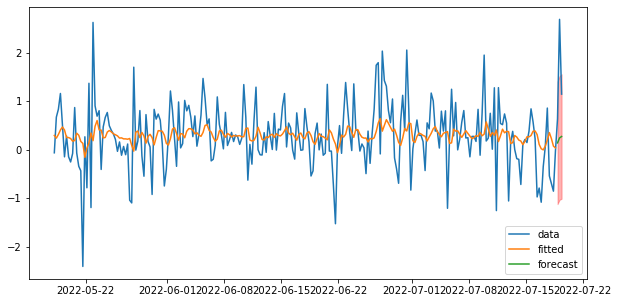

In [106]:
plot_result(model, aglt2['LogUtilization'], train['LogUtilization'], test['LogUtilization'])

In [107]:
def plot_test(model, test):
    test_pred, confint = model.predict(n_periods=Ntest, return_conf_int=True)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(test.index, test, label='data')
    ax.plot(test.index, test_pred, label='forecast')
    ax.fill_between(test.index,
                    confint[:,0],confint[:,1],
                    color='red',alpha=0.3)
    ax.legend();

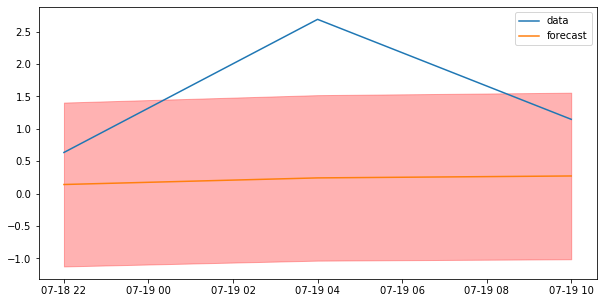

In [108]:
plot_test(model, test['LogUtilization'])

In [109]:
### forecast RMSE
def rmse(t, y):
    return np.sqrt(np.mean((t - y)**2))

In [113]:
print("ARIMA RMSE:", rmse(model.predict(Ntest), test['LogUtilization']))
print("Naive RMSE:", rmse(train.iloc[-1]['LogUtilization'], test['LogUtilization']))

ARIMA RMSE: 1.5276497451441553
Naive RMSE: 1.7446370934873292
